# **Mục lục:**

## Phần 1: Giới thiệu
- **1.1 Bối cảnh**
- **1.2 Mục đích**
- **1.3 Giới thiệu về bộ dữ liệu**

## Phần 2: Khám phá tập dữ liệu
- **2.1 Trích xuất tính năng để phân tích**
    - **Tổng quan tập dữ liệu**
    - **Dùng PCA để giảm chiều dữ liệu**
    - **Dùng VIF và Correlation bỏ bớt tính năng**    
- **2.2 Phân tích mô tả**

## Phần 3: Mô hình hóa dữ liệu
- **3.1 Giải quyết mất cân bằng dữ liệu**
- **3.2 Huấn luyện các mô hình dự đoán dữ liệu**
  - **3.2.1 Huấn luyện các model bị ảnh hưởng bởi đa cộng tuyến**
  - **3.2.2 Huấn luyện các model ít bị ảnh hưởng bởi đa cộng tuyến**
- **3.3 Đánh giá và chọn mô hình**
- **3.4 Đánh giá hiệu suất mô hình đã chọn dựa trên mô hình cơ bản**
- **3.5 Trực quan hóa kết quả**
- **3.6 Trực quan hóa mức đóng góp của biến dự đoán lên biến mục tiêu**

## Phần 4: Kết luận



#**Phần 1: Giới thiệu:**

##1.1 Bối cảnh:

Ngày nay, cùng với sự phát triển vượt bậc về kinh tế, nhu cầu làm giàu của con người càng tăng, và một trong những phương pháp được sử dụng là đầu tư tài chính vào các công ty như mở doanh nghiệp, góp vốn làm ăn qua cổ phiếu, trái phiếu... Vậy nên, việc dự báo 1 công ty có khả năng phá sản trong tương lai hay không là một trong những công việc quan trọng để bảo vệ các nhà đầu tư đồng thời giúp công ty quản lý rủi ro doanh nghiệp.

##1.2 Mục đích:

Mục đích của việc nghiên cứu các công ty có khả năng phá sản hay không giúp:
+ Bảo vệ các nhà đầu tư: Nghiên cứu để tăng tính minh bạch của các công ty, tìm ra thông tin chính xác giúp nhà đầu tư hiểu rõ hơn về tình hình doanh nghiệp, giảm rủi ro đầu tư vào các công ty có nguy cơ phá sản.
+ Quản lý rủi ro doanh nghiệp: đánh giá tình hình tài chính của bản thân, phát hiện sớm dấu hiệu bất ổn để lên kế hoạch ứng phó khắc phục.

Note: *Ở đây, tôi sẽ đứng trên phương diện nhà đầu tư cần bảo vệ tài sản của mình nhiều hơn*

##1.3 Giới thiệu về bộ dữ liệu:

Bộ dữ liệu phá sản từ Tạp chí kinh tế Đài Loan trong những năm 1999 – 2009 được lấy trên Kaggle. Các công ty phá sản được xác định dựa trên các quy định kinh doanh của Sở giao dịch chứng khoán Đài Loan.

*Ghi chú: Một công ty được niêm yết trên Sở Giao dịch Chứng khoán Đài Loan thường được coi là phá sản khi tổng nợ phải trả của công ty vượt quá tài sản, khiến công ty không thể trả được nợ dẫn đến bị chủ nợ kiện ra tòa, hoặc tự nộp đơn xin phá sản. Việc này được xác định qua quy trình pháp lý, thường bao gồm việc tòa án xem xét tình hình tài chính của công ty.*

#**Phần 2: Khám phá tập dữ liệu:**

In [1]:
# Nhập các thư viện cần thiết:

# Thư viện để thao tác với ma trận và dataframe
import numpy as np
import pandas as pd

# Thư viện trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# Ẩn bớt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

# Thư viện xử lý dữ liệu mất cân bằng
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Nhập các model để huấn luyện từ thư viện tương ứng
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Nhập các chỉ số để đánh giá hiệu suất model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,precision_score, recall_score, accuracy_score, f1_score

#Thư viện tiền huấn luyện
from sklearn.model_selection import train_test_split, GridSearchCV

#Xử lý đa cộng tuyến
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Giảm chiều dữ liệu
from sklearn.decomposition import PCA


##2.1 Trích xuất tính năng để phân tích:

Ở đây ta sẽ chuẩn bị 3 tập dữ liệu cho model:
- Các thuật toán LogisticRegression(), Kmeans(), GaussianNB() bị ảnh hưởng đáng kể với đa cộng tuyến giữa các biến nên xử lý đa cộng tuyến bằng 2 cách:
  - **1, Tập pca_data**: Dùng PCA giảm chiều dữ liệu.
  - **2, Tập vif_data**: Dùng Correlation + VIF bỏ bớt các biến đặc trưng có tương quan cao với nhau.

- Các thuật toán dựa trên nền tảng cây quyết định không bị ảnh hưởng nhiều bởi đa cộng tuyến nên ta giữ lại tập dữ liệu gốc chứa đầy đủ thông tin.
  - **3, Tập data**

### Tổng quan tập dữ liệu:

In [2]:
# Xem 5 hàng đầu tiên của tập dữ liệu
data=pd.read_csv('/content/data.csv')
data.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


- Biến mục tiêu y = 'Bankrupt?'
- Tất cả các biến còn lại là biến dự đoán.

In [3]:
#Xem hình dạng tập dữ liệu
data.shape

(6819, 96)

Bộ dữ liệu gồm có 6819 hàng và 96 cột (tính năng).

Vì tập dữ liệu này có quá nhiều tính năng nên ta cần bỏ bớt:
+ Các tính năng có correlation thấp với biến mục tiêu y, nghĩa là không đóng góp đáng kể cho biến mục tiêu.
+ Các tính năng có đa cộng tuyến mạnh với các biến dự đóan còn lại.


In [4]:
# Kiểm tra dữ liệu thiếu:
(data.isna().sum()>0).sum()

0

Không có dữ liệu thiếu

In [5]:
#Kiểm tra dữ liệu trùng lặp:
data.duplicated().sum()

0

Không có dữ liệu trùng lặp

###Dùng PCA để giảm chiều dữ liệu:

PCA là 1 kỹ thuật giảm chiều dữ liệu trên nền tảng đổi hệ quy chiếu của dữ liệu gốc nhằm đưa thông tin của dữ liệu về ít tính năng hơn giúp loại bỏ tương quan giữa các tính năng, cải thiện hiệu suất của mô hình học máy.

Text(0.5, 1.0, 'Biểu đồ phần trăm giải thích dữ liệu theo số chiều')

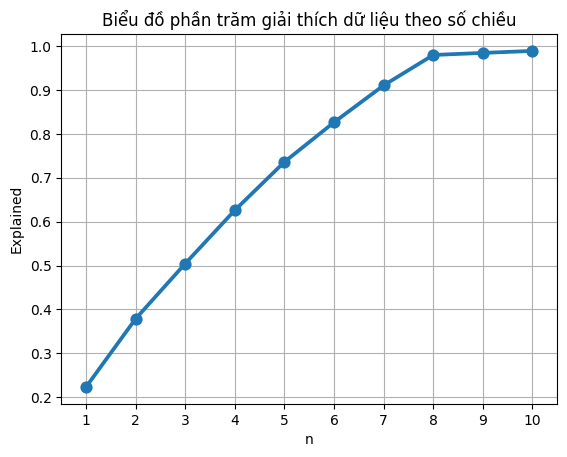

In [6]:
pca_data=data.copy()
pca_data.drop(columns=['Bankrupt?'])
n=[]
explained=[]
for i in range(1,11):
  pca=PCA(n_components=i)
  pca.fit_transform(pca_data)
  n.append(i)
  explained.append(sum(pca.explained_variance_ratio_))
sns.pointplot(x=n,y=explained)
plt.grid()
plt.xlabel('n'),
plt.ylabel('Explained')
plt.title('Biểu đồ phần trăm giải thích dữ liệu theo số chiều')

In [7]:
# Chọn n_components=8
pca=PCA(n_components=8)
pca_data=pca.fit_transform(pca_data)
sum(pca.explained_variance_ratio_)

0.9795802309824577

Chọn số chiều dữ liệu n=8 giữ lại được tối ưu thông tin của bộ dữ liệu cũ nhất: 98% (khi tăng lên n=9 thì thông tin được đưa vào thêm không đáng kể)

In [8]:
# Thêm biến mục tiêu cho tập dữ liệu
pca_data=pd.DataFrame(pca_data)
pca_data['Bankrupt?']=data['Bankrupt?']
pca_data.head()

,0,1,2,3,4,5,6,7,Bankrupt?
0,2.165330e+09,-3.814949e+07,-3.237615e+09,-2.063212e+09,1.969494e+09,-1.410239e+09,-8.723455e+08,-3.342048e+09,1
1,4.902366e+08,8.463795e+09,8.746100e+08,-3.292132e+09,1.383796e+09,-1.194097e+09,-2.313543e+08,-2.330575e+09,1
2,-2.620138e+09,-2.169966e+09,-1.239416e+09,8.771527e+08,2.812465e+09,-1.582306e+09,1.654892e+09,-4.584627e+08,1
3,3.249284e+09,5.987899e+09,-2.180465e+09,-4.385660e+09,2.566962e+09,1.061380e+09,7.876119e+09,4.758288e+09,1
4,7.604602e+09,-2.951427e+09,2.267775e+09,-2.370486e+09,1.647314e+09,-3.956955e+08,-4.681061e+08,2.215795e+09,1


###Dùng VIF và Correlation để bỏ bớt tính năng

1 cách khác để loại bỏ mối tương quan giữa các tính năng là dùng hệ số correlation để đo mối tương quan giữa chúng, những cặp biến có mối tương quan cao tiếp tục được đo giá trị VIF để loại bỏ.

####Bỏ bớt các cột có tương quan (correlation) thấp với biến mục tiêu:

In [9]:
#Tính hệ số tương quan để loại bỏ bớt những biến ít tác động vào kết quả
datacorr=data.corr()
datacorr['absBankrupt?']=datacorr['Bankrupt?'].abs()

# Chỉ lấy những cột có hệ số tương quan với biến mục tiêu <=-0.15 hoặc >=0.15
datacorr=datacorr[datacorr['absBankrupt?']>=0.15].sort_values(by='absBankrupt?', ascending=False)
datacorr.drop(columns=['absBankrupt?'], inplace=True)
print(datacorr.shape)
print(datacorr.index)

(22, 96)
Index(['Bankrupt?', ' Net Income to Total Assets',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' ROA(C) before interest and depreciation before interest',
       ' Net worth/Assets', ' Debt ratio %',
       ' Persistent EPS in the Last Four Seasons',
       ' Retained Earnings to Total Assets',
       ' Net profit before tax/Paid-in capital',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Current Liability to Assets', ' Working Capital to Total Assets',
       ' Net Income to Stockholder's Equity', ' Borrowing dependency',
       ' Current Liability to Current Assets', ' Liability to Equity',
       ' Net Value Per Share (A)', ' Net Value Per Share (B)',
       ' Net Value Per Share (C)', ' Current Liabilities/Equity',
       ' Current Liability to Equity'],
      dtype='object')


Ta chọn được 22 tính năng trên bao gồm cả biến mục tiêu là 'Bankrupt?'

####Bỏ bớt các cột (biến) có đa cộng tuyến mạnh:

Variance Inflation Factor (VIF) giúp xác định mức độ đa cộng tuyến trong một mô hình hồi quy. Ngưỡng VIF và mức độ đa cộng tuyến:

- VIF ≤ 1: Không có đa cộng tuyến hoặc rất ít. Biến dự đoán không bị giải thích nhiều bởi các biến khác trong mô hình.

- 1 < VIF ≤ 5: Mức độ đa cộng tuyến vừa phải. Biến dự đoán có thể có một số mối liên hệ với các biến khác, nhưng thường không gây ra vấn đề nghiêm trọng.

- 5 < VIF ≤ 10: Mức độ đa cộng tuyến cao. Biến dự đoán có thể bị giải thích nhiều bởi các biến khác. Đây là dấu hiệu cần điều tra thêm. Có thể cần cân nhắc loại bỏ hoặc kết hợp các biến, hoặc sử dụng kỹ thuật khác để xử lý vấn đề đa cộng tuyến.

- VIF > 10: Rất cao và thường chỉ ra đa cộng tuyến nghiêm trọng. Biến dự đoán có mối liên hệ mạnh với các biến khác, điều này có thể làm giảm chất lượng của mô hình và làm cho hệ số hồi quy không ổn định. Cần thực hiện các bước để xử lý đa cộng tuyến.

In [10]:
# Xử lý đa cộng tuyến bằng VIF:
vifx=data[datacorr.index].copy().drop(columns=['Bankrupt?'])
vifx['Intercept']=1

# Tạo 1 dataframe để lưu các tính năng và mức độ đa cộng tuyến tương ứng
vif_data=pd.DataFrame()
vif_data['feature']=vifx.columns
vif_data['VIF']=[variance_inflation_factor(vifx.values,i) for i in range(vifx.shape[1])]
vif_data=round(vif_data.sort_values(by='VIF', ascending=False),0)

# Taọ thêm 1 cột 'corr with Bankrupt?' để thể hiện mức độ tương quan của từng tính năng với 'Bankrupt?'
vif_data=vif_data[vif_data['feature']!='Intercept']
def corre(x):
  a=np.corrcoef(data[x],data['Bankrupt?'])
  return a[0,1]
vif_data['corr with Bankrupt?']=vif_data['feature'].apply(corre)
vif_data

,feature,VIF,corr with Bankrupt?
20,Current Liability to Equity,inf,0.153828
4,Net worth/Assets,inf,-0.250161
5,Debt ratio %,inf,0.250161
19,Current Liabilities/Equity,inf,0.153828
16,Net Value Per Share (A),3858.0,-0.165465
18,Net Value Per Share (C),3078.0,-0.164784
17,Net Value Per Share (B),773.0,-0.165399
2,ROA(B) before interest and depreciation after...,87.0,-0.273051
3,ROA(C) before interest and depreciation befor...,56.0,-0.260807
15,Liability to Equity,43.0,0.166812


Tuy có một số biến có độ tương quan khá ổn với biến mục tiêu nhưng do mức độ đa cộng tuyến với các biến còn lại quá cao nên ta ko thể lấy nó.

In [11]:
# Lấy danh sách tên các cột có đa cộng tuyến VIF<=5
data_col=vif_data[vif_data['VIF']<=5]['feature']
data_col=data_col.values.tolist()
data_col.append('Bankrupt?')
data_col

[' Current Liability to Assets',
 " Net Income to Stockholder's Equity",
 ' Retained Earnings to Total Assets',
 ' Working Capital to Total Assets',
 ' Current Liability to Current Assets',
 'Bankrupt?']

In [12]:
#Tạo tập dữ liệu mới
vif_data=data[data_col]

In [13]:
# Xem 5 hàng dữ liệu đầu tiên của tập dữ liệu mới
vif_data.head()

,Current Liability to Assets,Net Income to Stockholder's Equity,Retained Earnings to Total Assets,Working Capital to Total Assets,Current Liability to Current Assets,Bankrupt?
0,0.147308,0.827890,0.903225,0.672775,0.118250,1
1,0.056963,0.839969,0.931065,0.751111,0.047775,1
2,0.098162,0.836774,0.909903,0.829502,0.025346,1
3,0.098715,0.834697,0.906902,0.725754,0.067250,1
4,0.110195,0.839973,0.913850,0.751822,0.047725,1


In [14]:
# Loại bỏ khoảng trắng đầu tên cột để dễ tao tác hơn
vif_data.columns=['Current Liability to Assets',
 "Net Income to Stockholder's Equity",
 'Retained Earnings to Total Assets',
 'Working Capital to Total Assets',
 'Current Liability to Current Assets',
 'Bankrupt?']

In [15]:
# Xem hình dạng tập dữ liệu mới
vif_data.shape

(6819, 6)

Tập dữ liệu này gồm 6819 hàng và 6 cột

In [16]:
# Thông tin mô tả tổng quan
vif_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Current Liability to Assets          6819 non-null   float64
 1   Net Income to Stockholder's Equity   6819 non-null   float64
 2   Retained Earnings to Total Assets    6819 non-null   float64
 3   Working Capital to Total Assets      6819 non-null   float64
 4   Current Liability to Current Assets  6819 non-null   float64
 5   Bankrupt?                            6819 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 319.8 KB


Bộ dữ liệu mới này gồm có 6 biến trong đó 5 biến dự đoán và 1 biến mục tiêu. Dưới đây là thông tin mô tả về các biến:

| Tên biến | Mô Tả | Kiểu dữ liệu |
|--------|--------------------------------|------|
| Current Liability to Assets |$\frac{ Tổng\  nợ\ ngắn\ hạn }{Tổng\ tài\ sản}$ | số |
| Net Income to Stockholder's Equity | $\frac{Lợi\ nhuận\ ròng}{Vốn\, chủ\ sở\ hữu}$ | số |
| Retained Earnings to Total Assets | $\frac{Lợi\ nhuận\ giữ\ lại}{Tổng\ tài\ sản}$|số|
| Working Capital to Total Assets | $\frac{Vốn\ lưu\ động}{Tổng\ tài\ sản}$ | số |
|Current Liability to Current Assets|$\frac{Tổng\ nợ\ ngắn\ hạn}{Tổng\ tài\ sản\ ngắn\ hạn}$|số|
| Bankrupt? | Phá sản hoặc không (biến mục tiêu) | nhị phân (1/0) |

##2.2 Phân tích mô tả:

In [17]:
# Xem 10 biến tương quan với biến mục tiêu cao nhất:
datacorr.head(10)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
Bankrupt?,1.000000,-0.260807,-0.282941,-0.273051,-0.100043,-0.099445,-0.000230,-0.008517,-0.008857,-0.016593,...,-0.315457,0.035104,-0.005547,-0.100044,-0.180987,0.166812,0.010508,-0.005509,NaN,-0.083048
Net Income to Total Assets,-0.315457,0.887670,0.961552,0.912040,0.300143,0.298155,0.028482,0.048587,0.045390,0.028423,...,1.000000,-0.105201,0.011942,0.300146,0.328492,-0.159697,-0.010463,0.012746,NaN,0.073916
ROA(A) before interest and % after tax,-0.282941,0.940124,1.000000,0.955741,0.326969,0.324956,0.032053,0.053518,0.049474,0.029649,...,0.961552,-0.098900,0.011463,0.326971,0.291744,-0.141039,-0.011515,0.013372,NaN,0.057887
ROA(B) before interest and depreciation after tax,-0.273051,0.986849,0.955741,1.000000,0.333749,0.331755,0.035212,0.053726,0.049952,0.022366,...,0.912040,-0.089088,0.007523,0.333750,0.280617,-0.142838,-0.014663,0.011473,NaN,0.056430
ROA(C) before interest and depreciation before interest,-0.260807,1.000000,0.940124,0.986849,0.334719,0.332755,0.035725,0.053419,0.049222,0.020501,...,0.887670,-0.071725,0.008135,0.334721,0.274287,-0.143629,-0.016575,0.010573,NaN,0.052416
Net worth/Assets,-0.250161,0.261427,0.259972,0.264734,0.245460,0.245606,-0.010397,0.003906,0.006174,0.033214,...,0.281422,-0.041055,0.050218,0.245461,0.123986,-0.349250,-0.017982,-0.012571,NaN,0.625879
Debt ratio %,0.250161,-0.261427,-0.259972,-0.264734,-0.245460,-0.245606,0.010397,-0.003906,-0.006174,-0.033214,...,-0.281422,0.041055,-0.050218,-0.245461,-0.123986,0.349250,0.017982,0.012571,NaN,-0.625879
Persistent EPS in the Last Four Seasons,-0.219560,0.775006,0.764828,0.764597,0.256722,0.254753,0.020420,0.033726,0.030768,0.018148,...,0.691152,-0.033509,0.003791,0.256723,0.222961,-0.114114,-0.018829,0.008039,NaN,0.036722
Retained Earnings to Total Assets,-0.217779,0.650217,0.718013,0.673738,0.164579,0.163013,0.021280,0.036236,0.034573,0.021105,...,0.794189,-0.170156,0.013460,0.164583,0.247707,-0.109810,-0.013766,0.009603,NaN,0.042936
Net profit before tax/Paid-in capital,-0.207857,0.753339,0.758234,0.726003,0.248104,0.246256,0.020015,0.033900,0.030568,0.019483,...,0.683623,-0.029308,0.007939,0.248106,0.215690,-0.104149,-0.018358,0.008172,NaN,0.031292


In [18]:
# Lấy 5 biến tương quan correlation cao nhất với biến mục tiêu 'Bankrupt?' để phân tích:
list_features=[' Net Income to Total Assets',
               ' Net worth/Assets',
               ' Debt ratio %',
               ' Persistent EPS in the Last Four Seasons',
               ' Retained Earnings to Total Assets',
               'Bankrupt?']
list_features

[' Net Income to Total Assets',
 ' Net worth/Assets',
 ' Debt ratio %',
 ' Persistent EPS in the Last Four Seasons',
 ' Retained Earnings to Total Assets',
 'Bankrupt?']

<Axes: >

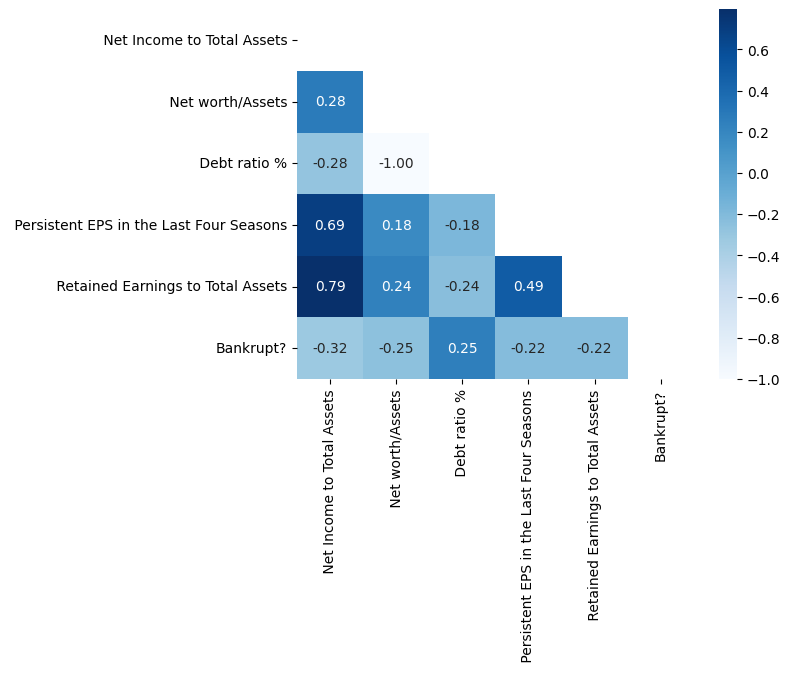

In [19]:
# Trực quan hóa ma trận tương quan
mask=np.triu(data[list_features].corr())
sns.heatmap(data[list_features].corr(), annot=True, fmt='0.2f', mask=mask, cmap='Blues')

In [20]:
# Hàm trực quan hóa:
def visualize(column,y,data):

  fig,ax=plt.subplots(1,2,figsize=(15,5))
  sns.boxenplot(data=data,y=column, ax=ax[0],hue=y)
  ax[0].grid(linestyle='--')
  ax[0].set_title('Đồ thị boxplot theo {}'.format(column))

  q1, q9 = data[column].quantile([0.25, 0.75])
  mask = data[column].between(q1, q9)
  sns.boxplot(data=data[mask],y=column, ax=ax[1],hue=y)
  ax[1].grid(linestyle='--')
  ax[1].set_title('Đồ thị boxplot theo {} không có outlier'.format(column))

  plt.show()

In [21]:
#Bảng phân tích mô tả
round(data[list_features].groupby('Bankrupt?').describe(),2).T

Bankrupt?                                             0       1
 Net Income to Total Assets              count  6599.00  220.00
                                         mean      0.81    0.74
                                         std       0.04    0.08
                                         min       0.00    0.41
                                         25%       0.80    0.72
                                         50%       0.81    0.77
                                         75%       0.83    0.79
                                         max       1.00    0.82
 Net worth/Assets                        count  6599.00  220.00
                                         mean      0.89    0.81
                                         std       0.05    0.06
                                         min       0.00    0.47
                                         25%       0.85    0.79
                                         50%       0.89    0.81
                                         75%       0.93    0.84
                                         max       1.00    1.00
 Debt ratio %                            count  6599.00  220.00
                                         mean      0.11    0.19
                                         std       0.05    0.06
                                         min       0.00    0.00
                                         25%       0.07    0.16
                                         50%       0.11    0.19
                                         75%       0.15    0.21
                                         max       1.00    0.53
 Persistent EPS in the Last Four Seasons count  6599.00  220.00
                                         mean      0.23    0.19
                                         std       0.03    0.03
                                         min       0.08    0.00
                                         25%       0.22    0.18
                                         50%       0.23    0.20
                                         75%       0.24    0.21
                                         max       1.00    0.25
 Retained Earnings to Total Assets       count  6599.00  220.00
                                         mean      0.94    0.90
                                         std       0.02    0.04
                                         min       0.00    0.73
                                         25%       0.93    0.89
                                         50%       0.94    0.91
                                         75%       0.95    0.93
                                         max       1.00    0.96

| Tên biến |Công thức|  Mô Tả | Kiểu dữ liệu |
|--------|-----------|-------------------------|------|
| Net Income to Total Assets |$\frac{ Lợi\  nhuận\ ròng }{Tổng\ tài\ sản}$| - Lợi nhuận ròng là phần lợi nhuận công ty nhận được sau khi trừ hết tất cả chi phí.  | số |
|||- Chỉ số này đo lường khả năng sinh lời của công ty, cho biết cứ mỗi đô la tài sản, công ty tạo ra bao nhiêu lợi nhuận ròng.
|||- Chỉ số càng cao, công ty càng sử dụng tài sản của mình hiệu quả.
| Net worth/Assets | $\frac{Vốn\ chủ\ sở\ hữu}{Tổng\ tài\ sản}$| - Chỉ số này đo lường tỷ lệ giữa giá trị ròng của công ty (tổng tài sản - tổng nợ phải trả) và tổng tài sản. |số|
|||- Nó cho biết tỷ lệ của vốn chủ sở hữu trong tài sản. Tỷ lệ này càng cao, công ty càng được đảm bảo.
| Debt ratio % | $\frac{Tổng\ nợ}{Tổng\ tài\ sản}$| - Chỉ số tài chính đo lường mức độ tỷ lệ tổng nợ trong tổng tài sản của công ty.| số |
|||- Tỷ lệ này càng cao, công ty càng phụ thuộc vào nợ, rủi ro tài chính cũng tăng.
|Persistent EPS in the Last Four Seasons| $\frac{Lợi\ nhuận\ ròng}{Lượng\ cổ\ phiếu\ đang\ lưu\ hành}$| - Lợi nhuận trên mỗi cổ phần của công ty. | số |
|||- Nếu chỉ số này ổn định hoặc tăng cho thấy công ty có khả năng duy trì lợi nhuận lâu dài,
|||ngược lại, sự giảm sút EPS là dấu hiệu cảnh báo cho sự bất ổn về lợi nhuận trong tương lai.
| Retained Earnings to Total Assets| $\frac{Lợi\ nhuận\ giữ\ lại}{Tổng\ tài\ sản}$|- Phần lợi nhuận ròng mà công ty giữ lại sau khi trả cổ tức cho các cổ đông. | số |
|||- Công ty giữ lại lợi nhuận để tái đầu tư vào hoạt động kinh doanh, mua sắm tài sản mới, hoặc trả nợ.
|||- Lợi nhuận giữ lại thường được tính bằng cách cộng dồn lợi nhuận giữ lại từ các kỳ trước với lợi nhuận giữ lại trong kỳ hiện tại.
| Bankrupt? | |Phá sản hoặc không (biến mục tiêu) | nhị phân (1/0) |

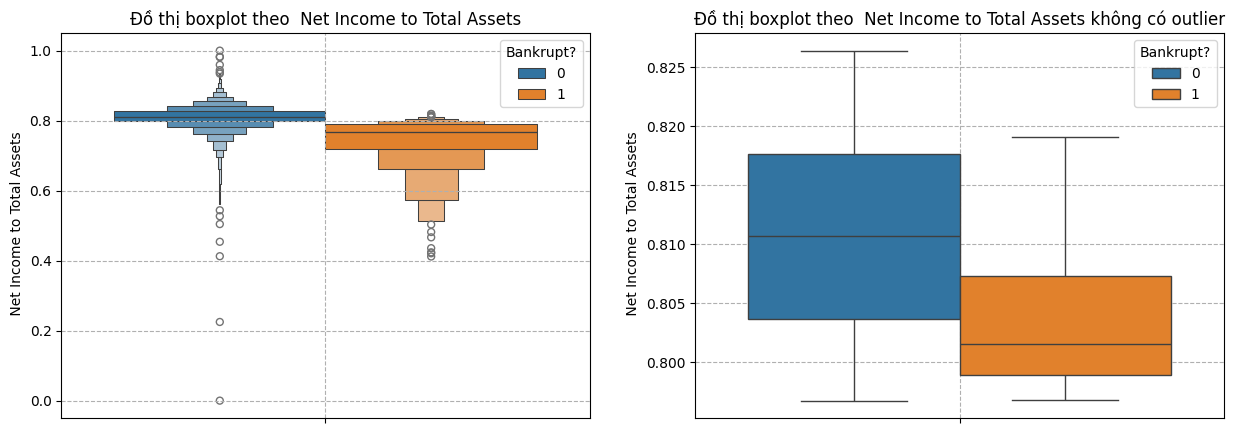

In [22]:
# Trực quan hóa ' Net Income to Total Assets',
visualize(list_features[0],'Bankrupt?',data[list_features])

- Có 6599 công ty không phá sản, 220 công ty phá sản
- Tổng quan đồ thị ta thấy trung bình tỷ lệ lợi nhuận ròng/tổng tài sản của các công ty phá sản thấp hơn công ty còn hoạt động ( 0.74 < 0.81)

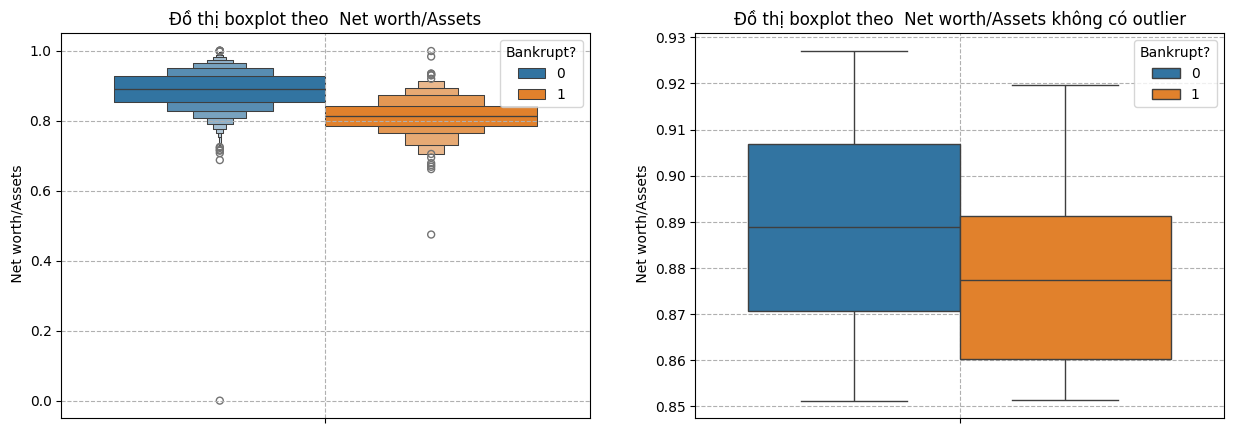

In [23]:
#Trực quan hóa ' Net worth/Assets',
visualize(list_features[1],'Bankrupt?',data[list_features])

- Trung bình tỷ lệ vốn chủ sở hữu/tổng tài sản của các công ty phá sản thấp hơn công ty còn hoạt động ( 0.81 < 0.89)

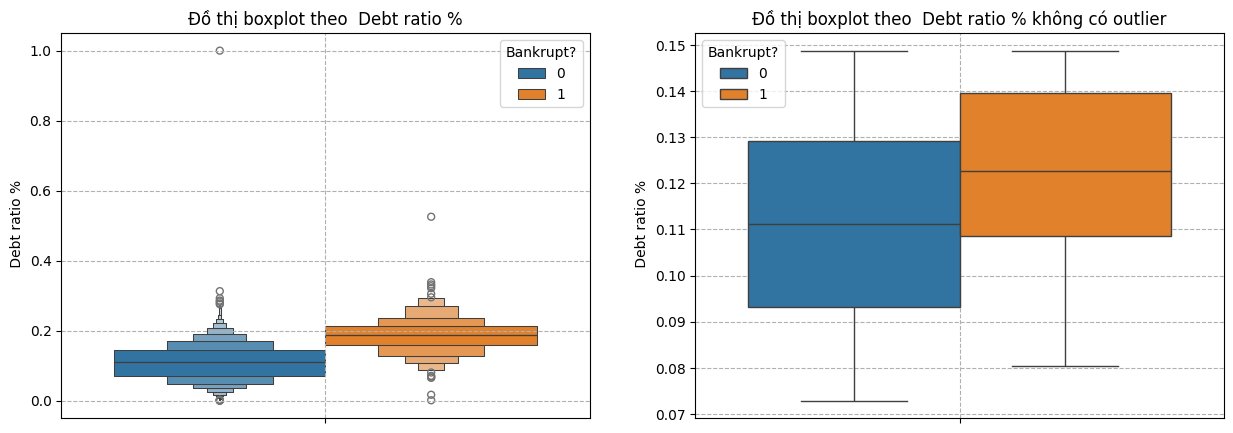

In [24]:
#Trực quan hóa  ' Debt ratio %'
visualize(list_features[2],'Bankrupt?',data[list_features])

- Trung bình tỷ lệ tổng nợ/tổng tài sản của các công ty phá sản cao hơn công ty còn hoạt động ( 0.19 > 0.11)

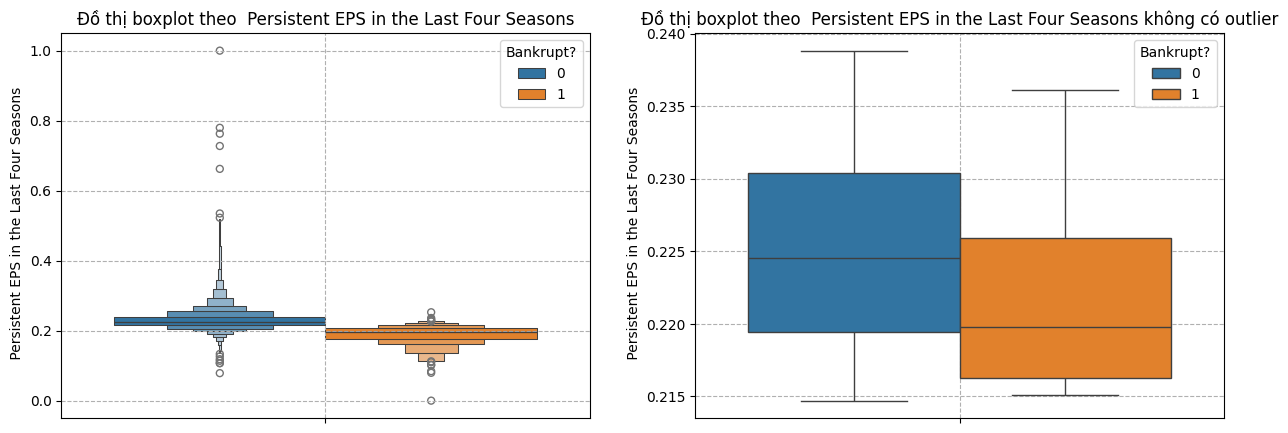

In [25]:
#Trực quan hóa ' Persistent EPS in the Last Four Seasons'
visualize(list_features[3],'Bankrupt?',data[list_features])

- Trung bình tỷ lệ lợi nhuận trên 1 cổ phiếu của các công ty phá sản thấp hơn công ty còn hoạt động ( 0.19 < 0.23)

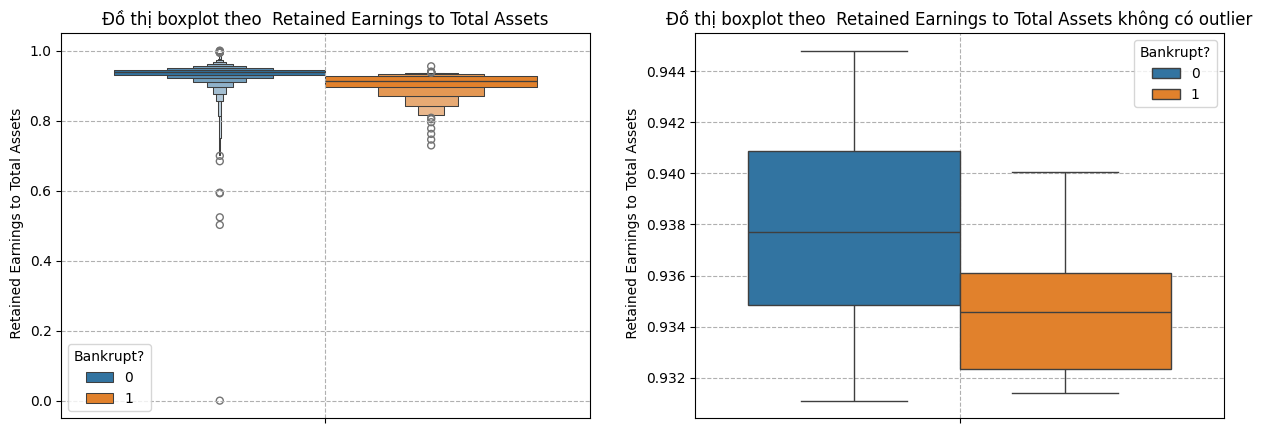

In [26]:
#Trực quan hóa ' Retained Earnings to Total Assets'
visualize(list_features[4],'Bankrupt?',data[list_features])

- Trung bình tỷ lệ lợi nhuận giữ lại/ tổng tài sản của các công ty phá sản thấp hơn công ty còn hoạt động ( 0.90< 0.94)

# **Phần 3: Mô hình hóa dữ liệu:**

##3.1 Giải quyết mất cân bằng dữ liệu:

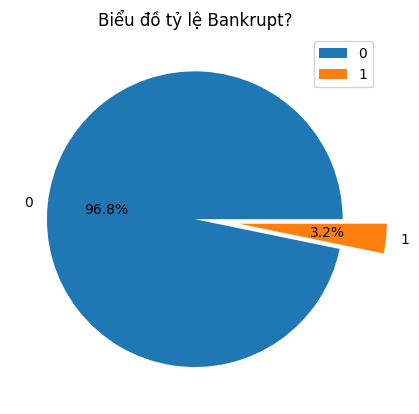

In [27]:
# Trực quan hóa tỷ lệ phá sản lên biểu đồ
count_bankrupt=data['Bankrupt?'].value_counts(normalize=True)*100
plt.pie(x=count_bankrupt,labels=count_bankrupt.index ,autopct='%0.1f%%', explode=[0,0.3] )
plt.title('Biểu đồ tỷ lệ Bankrupt?')
plt.legend()

Nhìn biểu đồ ta thấy tỷ lệ phá sản chỉ chiếm 3.2% - một lượng rất nhỏ trong tổng thể. Vì vậy, các mô hình sẽ tập trung học phần đa số, bỏ qua phần thiểu số làm giảm hiệu suất dự đoán cho phần thiểu số. Để giải quyết điều này ta có 3 cách:
- Tăng mẫu cho phần thiểu số bằng cách tạo ra các mẫu mới từ việc sao chép các mẫu cũ với OverSampling.
- Tăng mẫu cho phần thiểu số bằng cách tạo mẫu tổng hợp từ các mẫu thiểu số có sẵn với Smote.
- Giảm mẫu phần đa số bằng UnderSampling.

In [28]:
resamples=[RandomOverSampler(random_state=0),RandomUnderSampler(random_state=0),SMOTE(random_state=0)]
resamples

[RandomOverSampler(random_state=0),
 RandomUnderSampler(random_state=0),
 SMOTE(random_state=0)]

##3.2 Huấn luyện các mô hình dự đoán dữ liệu:


In [29]:
# Hàm huấn luyện mô hình
def training(data,models,resample=None):

  x=data.drop(columns=['Bankrupt?'])
  y=data['Bankrupt?']
  x_train,x_test,y_train, y_test=train_test_split(x,y,test_size=0.2, stratify=y, random_state=0)

  if resample is not None:
    x_train, y_train= resample.fit_resample(x_train , y_train)

  results=pd.DataFrame()

  for i, model in enumerate(models):
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)

    result=pd.DataFrame({'Model':[model.__class__.__name__],
                      'Precision': [precision_score(y_test,y_pred)],
                      'Recall': [recall_score(y_test,y_pred)],
                      'Accuracy': [accuracy_score(y_test,y_pred)],
                      'F1_score':[f1_score(y_test,y_pred)]
                      })
    results=pd.concat([results,result],axis=0)

  return results

###3.2.1 Huấn luyện các model bị ảnh hưởng bởi đa cộng tuyến cùng tập dữ liệu tương ứng:

In [30]:
# Tạo list để lưu trữ model:
list_model_multidata=[]

# Dùng model LogisticRegression để dự đoán:
lr=LogisticRegression()
list_model_multidata.append(lr)

# Dùng model Naive_Bayes để dự đoán:
nb=GaussianNB()
list_model_multidata.append(nb)

# Dùng model Kmeans để phân cụm:
km=KMeans(n_clusters=2)
list_model_multidata.append(km)

list_model_multidata

[LogisticRegression(), GaussianNB(), KMeans(n_clusters=2)]

#### Tập vif_data:

In [31]:
# Tập vif_data:
vif_results=pd.DataFrame()
for resample in resamples:
  result=training(vif_data,list_model_multidata,resample=resample)
  result['Resample']=resample.__class__.__name__
  vif_results=pd.concat([vif_results,result],axis=0)
vif_results['Model']=vif_results['Model']+ vif_results['Resample']
vif_results.drop(columns=['Resample'], inplace=True)

vif_results.sort_values(by=['F1_score','Recall'], ascending=[False,False], inplace=True)
vif_results

,Model,Precision,Recall,Accuracy,F1_score
0,GaussianNBRandomUnderSampler,0.169643,0.431818,0.913490,0.243590
0,GaussianNBRandomOverSampler,0.200000,0.295455,0.939150,0.238532
0,KMeansSMOTE,0.142132,0.636364,0.864370,0.232365
0,GaussianNBSMOTE,0.179487,0.318182,0.931085,0.229508
0,LogisticRegressionRandomOverSampler,0.121569,0.704545,0.826246,0.207358
0,LogisticRegressionSMOTE,0.117424,0.704545,0.819648,0.201299
0,LogisticRegressionRandomUnderSampler,0.111111,0.772727,0.793255,0.194286
0,KMeansRandomOverSampler,0.013491,0.363636,0.121701,0.026016
0,KMeansRandomUnderSampler,0.012291,0.318182,0.153226,0.023669


####Tập pca_data

In [32]:
# Tập vif_data:
pca_results=pd.DataFrame()
for resample in resamples:
  result=training(pca_data,list_model_multidata,resample=resample)
  result['Resample']=resample.__class__.__name__
  pca_results=pd.concat([pca_results,result],axis=0)
pca_results['Model']=pca_results['Model']+ pca_results['Resample']
pca_results.drop(columns=['Resample'], inplace=True)

pca_results.sort_values(by=['F1_score','Recall'], ascending=[False,False],inplace=True)
pca_results

,Model,Precision,Recall,Accuracy,F1_score
0,KMeansSMOTE,0.084577,0.386364,0.845308,0.138776
0,GaussianNBSMOTE,0.056738,0.727273,0.601173,0.105263
0,GaussianNBRandomOverSampler,0.057203,0.613636,0.661290,0.104651
0,GaussianNBRandomUnderSampler,0.056911,0.636364,0.648094,0.104478
0,LogisticRegressionRandomOverSampler,0.049005,0.727273,0.535924,0.091822
0,LogisticRegressionSMOTE,0.046110,0.727273,0.505865,0.086721
0,LogisticRegressionRandomUnderSampler,0.046200,0.704545,0.521261,0.086713
0,KMeansRandomOverSampler,0.034555,0.750000,0.315982,0.066066
0,KMeansRandomUnderSampler,0.033934,0.727273,0.323314,0.064843


###3.2.2 Huấn luyện các model ít bị ảnh hưởng bởi đa cộng tuyến:

Các model dưới đây dựa trên nền tảng cây quyết định nên ít bị ảnh hưởng bởi đa cộng tuyến.

In [33]:
# Tạo list để lưu trữ model:
list_model_data=[]

# Dùng model DecisionTreeClassifier để dự đoán:
tree=DecisionTreeClassifier(random_state=0)
list_model_data.append(tree)

# Dùng model RandomForestClassifier để dự đoán:
randomforest_tree=RandomForestClassifier(random_state=0)
list_model_data.append(randomforest_tree)

# Dùng model XGBClassifier để dự đoán:
xgb=XGBClassifier(objective='binary:logistic')
list_model_data.append(xgb)

# Dùng model AdaBoostClassifier để dự đoán
adab=AdaBoostClassifier(random_state=0)
list_model_data.append(adab)

list_model_data

[DecisionTreeClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 AdaBoostClassifier(random_state=0)]

In [34]:
results=pd.DataFrame()
for resample in resamples:
  result=training(data,list_model_data,resample=resample)
  result['Resample']=resample.__class__.__name__
  results=pd.concat([results,result],axis=0)
results['Model']=results['Model']+results['Resample']
results.drop(columns=['Resample'], inplace=True)

results.sort_values(by=['F1_score','Recall'], ascending=[False,False],inplace=True)
results

,Model,Precision,Recall,Accuracy,F1_score
0,XGBClassifierRandomOverSampler,0.477273,0.477273,0.966276,0.477273
0,XGBClassifierSMOTE,0.416667,0.454545,0.961877,0.434783
0,RandomForestClassifierSMOTE,0.333333,0.477273,0.952346,0.392523
0,AdaBoostClassifierSMOTE,0.258621,0.681818,0.926686,0.375000
0,AdaBoostClassifierRandomOverSampler,0.246154,0.727273,0.919355,0.367816
0,RandomForestClassifierRandomOverSampler,0.428571,0.272727,0.964809,0.333333
0,RandomForestClassifierRandomUnderSampler,0.178261,0.931818,0.859238,0.299270
0,XGBClassifierRandomUnderSampler,0.175966,0.931818,0.857038,0.296029
0,DecisionTreeClassifierRandomOverSampler,0.274510,0.318182,0.950880,0.294737
0,DecisionTreeClassifierSMOTE,0.214286,0.409091,0.932551,0.281250


##3.3 Đánh giá và chọn mô hình


Phân tích vấn đề: Bài toán đưa ra là dự đoán phá sản, cho nên khi dự đoán (lấy phá sản là positive) sẽ có 4 trường hợp:
- True Positive (TP): Dự đoán đúng phá sản
- False Positive (FP): Dự đoán sai phá sản
- True Negative (TN): Dự đoán đúng không phá sản
- False Negative (FN): Dự đoán sai không phá sản

Ở đây trường hợp FN gây ra hậu quả nghiêm trọng hơn vì làm thất thoát nguồn vốn nhà đầu tư khi dự đoán 1 công ty không phá sản nhưng thực tế sẽ phá sản nên ta sẽ chú trọng chỉ số Recall hơn Precision.

Tuy nhiên, nếu một model dự đoán tất cả doanh nghiệp đều phá sản thì hệ số Recall cao nhưng dự đoán đó sẽ làm mất rất nhiều cơ hội đầu tư tốt cho nên ta cần chú trọng thêm chỉ số trung bình điều hòa giữa Recall và Precision là F1_score.

In [35]:
# Hàm Trực quan hóa các chỉ số
def pointchart(results):
  plt.figure(figsize=(10, 5))
  sns.pointplot(data=results, x='Model', y='Precision', color='b', label='Precision')
  sns.pointplot(data=results, x='Model', y='Recall', color='r', label='Recall')
  sns.pointplot(data=results, x='Model', y='F1_score', color='g', label='F1_score')
  plt.xticks(rotation=90)
  plt.grid(linestyle='--')
  plt.ylabel('Values of Metrics')
  plt.show()

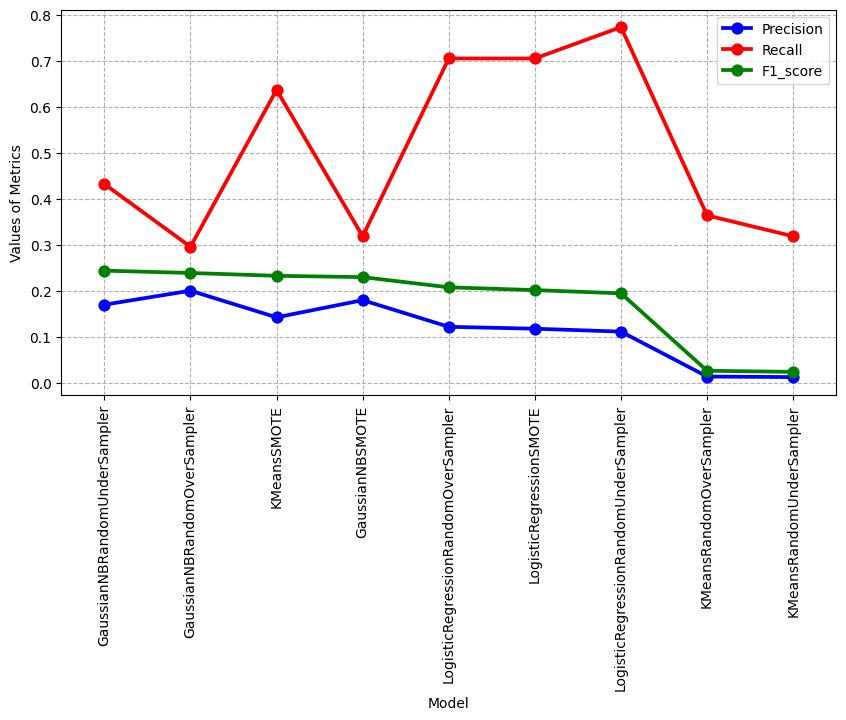

In [36]:
pointchart(vif_results)

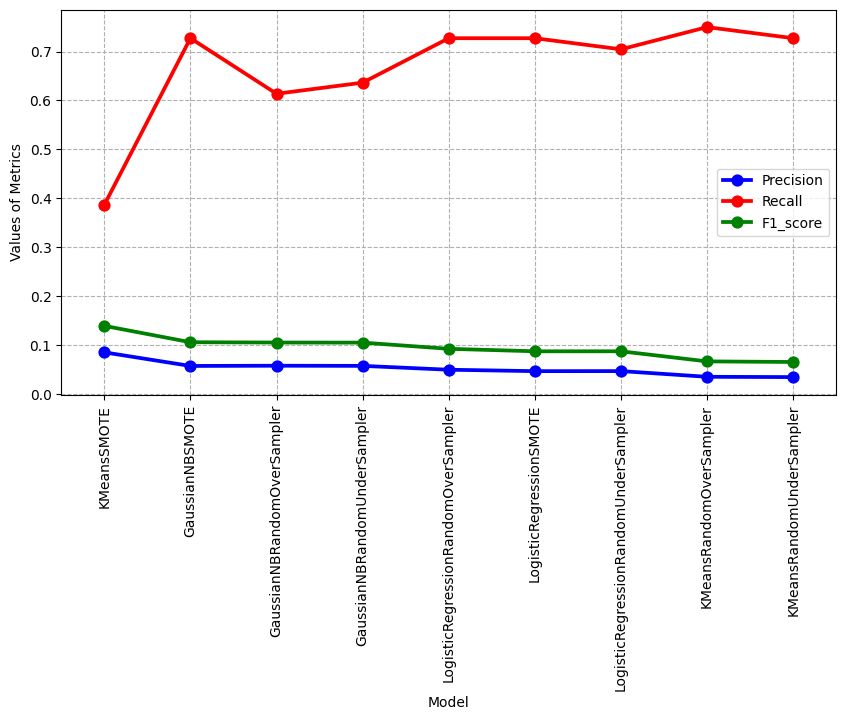

In [37]:
pointchart(pca_results)

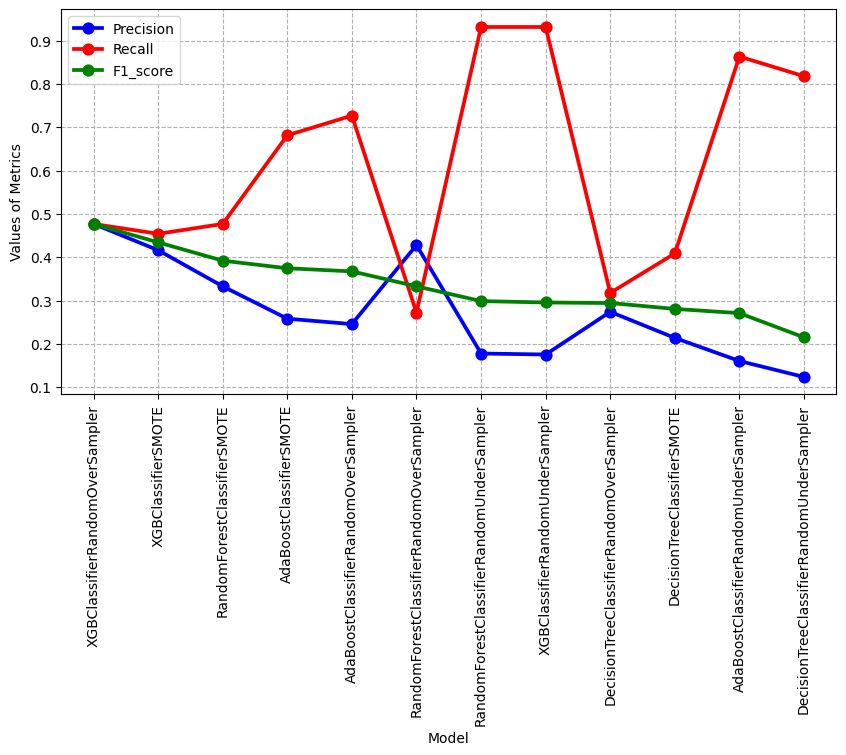

In [38]:
pointchart(results)

---> Với bộ dữ liệu này, nhìn vào 3 biểu đồ ta thấy 3 điều:

1, Việc huấn luyện trên tập data, vif_data, pca_data có hiệu suất giảm dần.

2, Dùng các model với sự kết hợp của các cây quyết định cho ra hiệu suất tốt hơn các model còn lại.

3, Model XGBClassifier() kết hợp với RandomOverSampler() được huấn luyện trên tập data cho ra chỉ số tốt nhất là:
- F1_score: 0.477
- Recall: 0.477
- Precision: 0.477

In [39]:
# Điều chỉnh tham số của model XGBClassifier:
most_important_metric='recall'

xgb=XGBClassifier(objective='binary:logistic')

scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1'
}

cv_params = {
    'n_estimators': [100,200],
    'max_depth': [3,6,9],
    'learning_rate': [0.3, 0.15],
    'subsample': [1],
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': [0, 0.1],
    'min_child_weight': [1, 2]
}

grid_xgb=GridSearchCV(xgb,cv_params,scoring=scoring,cv=5,refit=most_important_metric)

model=[grid_xgb]

In [40]:
# Huấn luyện dữ liệu
result=training(data,model,resample=RandomOverSampler(random_state=0))

In [41]:
result

,Model,Precision,Recall,Accuracy,F1_score
0,GridSearchCV,0.423077,0.5,0.961877,0.458333


---> F1_score sau khi điều chỉnh tham số thua tham số mặc định nên ta lấy mô hình với tham số mặc định

##3.4 Đánh giá hiệu suất mô hình đã chọn dựa trên mô hình cơ bản

Mô hình cơ bản là mô hình dự đoán ngẫu nhiên kết quả. Nếu mô hình ta tìm ra hiệu suất dự đoán thua 1 mô hình ngẫu nhiên thì mô hình đó mất ý nghĩa ứng dụng.

In [42]:
# So sánh hiệu suất của mô hình được chọn với mô hình cơ bản
base_model=[DummyClassifier(),xgb]
base_model_result = training(data, base_model, resample=RandomOverSampler(random_state=0))
base_model_result

,Model,Precision,Recall,Accuracy,F1_score
0,DummyClassifier,0.000000,0.000000,0.967742,0.000000
0,XGBClassifier,0.477273,0.477273,0.966276,0.477273


Nhìn trên ta thấy mô hình được chọn có hiệu suất tốt hơn hẵn mô hình cơ bản.

##3.5 Trực quan hóa kết quả

In [43]:
# Huấn luyện lại mô hình
x=data.drop(columns=['Bankrupt?'])
y=data['Bankrupt?']
x_train,x_test,y_train, y_test=train_test_split(x,y,test_size=0.2, stratify=y, random_state=0)
x_train, y_train= RandomOverSampler(random_state=0).fit_resample(x_train , y_train)
xgb.fit(x_train,y_train)
x_pred=xgb.predict(x_test)

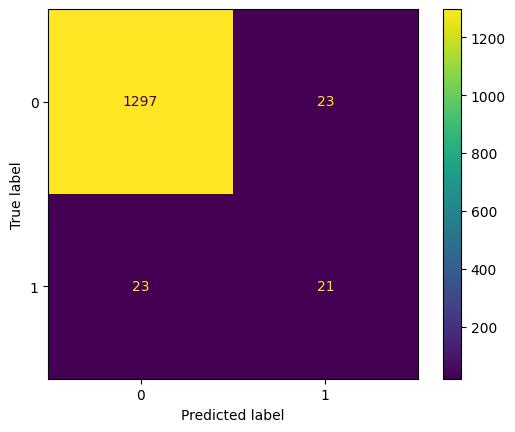

In [44]:
# Ma trận kết quả
ConfusionMatrixDisplay.from_estimator(xgb,x_test,y_test)

Với 1364 công ty được dự đoán. Mô hình đã đoán được:
- Đúng 1297/1320 công ty không phá sản.
- Đúng 21/44 công ty phá sản.
- Sai 23 công ty được đoán phá sản nhưng thực tế là không.
- Sai 23 công ty được đoán là không phá sản nhưng thực tế là có.

##3.6 Trực quan hóa mức đóng góp của biến dự đoán lên biến mục tiêu

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

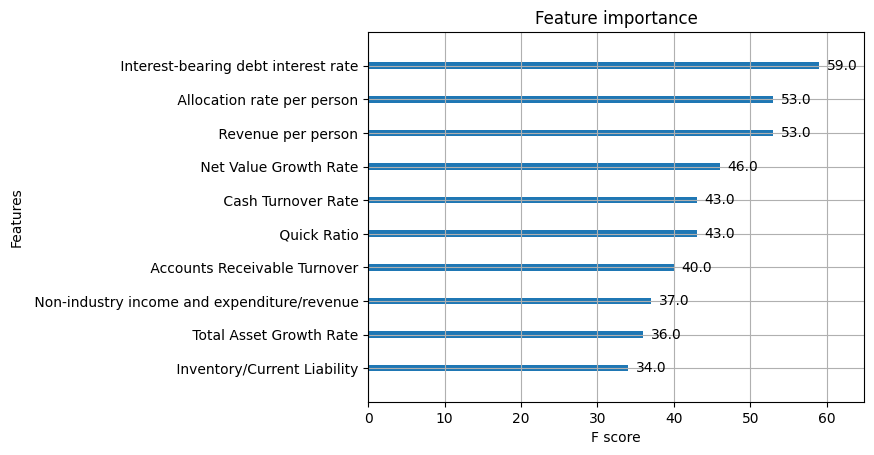

In [52]:
xgbplot=plot_importance(xgb, max_num_features=10,importance_type='weight')
xgbplot

In [56]:
features=[t.get_text() for t in xgbplot.get_yticklabels()]
features

[' Inventory/Current Liability',
 ' Total Asset Growth Rate',
 ' Non-industry income and expenditure/revenue',
 ' Accounts Receivable Turnover',
 ' Quick Ratio',
 ' Cash Turnover Rate',
 ' Net Value Growth Rate',
 ' Revenue per person',
 ' Allocation rate per person',
 ' Interest-bearing debt interest rate']

10 biến trên là 10 biến đóng góp nhiều nhất cho mô hình dự đoán gồm:
- Inventory/Current Liability: Hàng tồn kho/ Nợ ngắn hạn
- Total Asset Growth Rate: Tỷ lệ tăng trường tổng tài sản
- Non-industry income and expenditure/revenue: Thu nhập và chi tiêu ngoài ngành/ Doanh thu
- Accounts Receivable Turnover: (Vòng quay các khoản phải thu) Doanh thu thuần/ Các khoản phải thu trung bình
- Quick Ratio (Tỷ lệ thanh toán nhanh): (Tài sản ngắn hạn - Hàng tồn kho)/ Nợ ngắn hạn
- Cash Turnover Rate (Vòng quay tiền mặt): Doanh thu/Tiền mặt trung bình trong kỳ
- Net Value Growth Rate (Tỷ lệ tăng trưởng giá trị ròng): (Giá trị ròng cuồi kỳ- Giá trị ròng đầu kỳ)/Giá trị ròng đầu kỳ
- Revenue per Person (Doanh thu trên mỗi nhân viên): Tổng doanh thu/ Số lượng nhân viên
- Allocation Rate per Person (Tỷ lệ phân bổ trên mỗi nhân viên): (Chi phí quản lý + Chi phí chung)/ Số lượng nhân viên
- Interest-bearing Debt Interest Rate (Lãi suất nợ phải trả có lãi): Chi phí lãi vay/Nợ phải trả có lãi

# Phần 4: Kết luận


Trong dự án này, tôi đã áp dụng mô hình XGBoost kết hợp kỹ thuật tăng mẫu thiểu số để dự đoán khả năng phá sản của các doanh nghiệp. Sau khi thực hiện một loạt các thử nghiệm và đánh giá, mô hình XGBoost với các tham số mặc định đã cho thấy hiệu suất cao nhất trong các phương pháp dự đoán được thử nghiệm. Cụ thể, mô hình đạt được điểm số F1_score cao nhất là 0.47, cho thấy khả năng của nó trong việc cân bằng giữa độ chính xác (0.47) và độ nhạy (0.47) khi dự đoán các trường hợp phá sản.